# Trading

Let's start by installing MoreLINQ and importing the necessary namespace.

In [175]:
#r "nuget: morelinq, 4.0.0"

using System.Globalization;
using System.Net.Http;
using System.Text.RegularExpressions;
using MoreLinq;
using static System.Console;

// For informational purposes:
AppDomain.CurrentDomain.SetupInformation.TargetFrameworkName

Installed Packages morelinq, 4.0.0

.NETCoreApp,Version=v7.0

We're going to be buying and selling shares:

In [176]:
enum Trade { Buy, Sell }

Next, let's download the Microsoft stock price (ticker symbol MSFT) history for the last 5 years from Yahoo Finance.

In [177]:
const string ticker = "MSFT";
const int years = 5;

var endDate = DateTime.SpecifyKind(new(2023, 10, 1), DateTimeKind.Utc);
var startDate = endDate.AddYears(-years);
var startTimestamp = new DateTimeOffset(startDate).ToUnixTimeSeconds();
var endTimestamp = new DateTimeOffset(endDate).ToUnixTimeSeconds();
var url = new Uri(FormattableString.Invariant(@$"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={startTimestamp}&period2={endTimestamp}&interval=1d&events=history&includeAdjustedClose=true"));
var client = new HttpClient();
var csv = await client.GetStringAsync(url);

The response is CSV data, so let's parse that:

In [178]:
var lines = Regex.Split(csv, @"\r?\n");

Let's look at the headers line:

In [179]:
lines.First()

Date,Open,High,Low,Close,Adj Close,Volume

So we have 7 columns of data:

- `Date`
- `Open`
- `High`
- `Low`
- `Close`
- `Adj Close`
- `Volume`

Let's split each row into those fields. We will skip the header line and assume that the columns are always given in the above order. We will use `Split` to break-up each field by the comma (`,`) delimiter, but out of precation, we will only consider lines with exactly 7 fields.

In [180]:
var rows =
    from line in Regex.Split(csv, @"\r?\n")
                      .Skip(1)
    select line.Split(',', 7)
    into fields
    where fields.Length is 7
    select fields;

rows

index,value
0,"[ 2018-10-01, 114.750000, 115.680000, 114.730003, 115.610001, 109.532562, 18883100 ]"
1,"[ 2018-10-02, 115.300003, 115.839996, 114.440002, 115.150002, 109.096756, 20787200 ]"
2,"[ 2018-10-03, 115.419998, 116.180000, 114.930000, 115.169998, 109.115692, 16648000 ]"
3,"[ 2018-10-04, 114.610001, 114.760002, 111.629997, 112.790001, 106.860802, 34821700 ]"
4,"[ 2018-10-05, 112.629997, 113.169998, 110.639999, 112.129997, 106.235512, 29068900 ]"
5,"[ 2018-10-08, 111.660004, 112.029999, 109.339996, 110.849998, 105.022789, 29640600 ]"
6,"[ 2018-10-09, 111.139999, 113.080002, 110.800003, 112.260002, 106.358665, 26198600 ]"
7,"[ 2018-10-10, 111.239998, 111.500000, 105.790001, 106.160004, 100.579346, 61376300 ]"
8,"[ 2018-10-11, 105.349998, 108.930000, 104.199997, 105.910004, 100.342484, 63904300 ]"
9,"[ 2018-10-12, 109.010002, 111.239998, 107.120003, 109.570000, 103.810081, 47742100 ]"


Next, let's turn each row in an object with the data we need. We will use [`Fold`][Fold7] from MoreLINQ that allows folding the elements of sequence into a single value.

[Fold7]: https://morelinq.github.io/4.0/ref/api/html/M_MoreLinq_MoreEnumerable_Fold__2_14.htm

In [181]:
var data =
    from fields in rows
    select fields.Fold((date, open, hi, lo, close, ac, vol) => new
    {
        Date = DateOnly.Parse(date),
        Price = decimal.Parse(close),
    });

data

index value 0 { Date = 10/1/2018, Price = 115.610001 } Date 10/1/2018 Year 2018 Month 10 Day 1 DayOfWeek Monday DayOfYear 274 DayNumber 736967 Price 115.610001 1 { Date = 10/2/2018, Price = 115.150002 } Date 10/2/2018 Year 2018 Month 10 Day 2 DayOfWeek Tuesday DayOfYear 275 DayNumber 736968 Price 115.150002 2 { Date = 10/3/2018, Price = 115.169998 } Date 10/3/2018 Year 2018 Month 10 Day 3 DayOfWeek Wednesday DayOfYear 276 DayNumber 736969 Price 115.169998 3 { Date = 10/4/2018, Price = 112.790001 } Date 10/4/2018 Year 2018 Month 10 Day 4 DayOfWeek Thursday DayOfYear 277 DayNumber 736970 Price 112.790001 4 { Date = 10/5/2018, Price = 112.129997 } Date 10/5/2018 Year 2018 Month 10 Day 5 DayOfWeek Friday DayOfYear 278 DayNumber 736971 Price 112.129997 5 { Date = 10/8/2018, Price = 110.849998 } Date 10/8/2018 Year 2018 Month 10 Day 8 DayOfWeek Monday DayOfYear 281 DayNumber 736974 Price 110.849998 6 { Date = 10/9/2018, Price = 112.260002 } Date 10/9/2018 Year 2018 Month 10 Day 9 DayOfWeek Tuesday DayOfYear 282 DayNumber 736975 Price 112.260002 7 { Date = 10/10/2018, Price = 106.160004 } Date 10/10/2018 Year 2018 Month 10 Day 10 DayOfWeek Wednesday DayOfYear 283 DayNumber 736976 Price 106.160004 8 { Date = 10/11/2018, Price = 105.910004 } Date 10/11/2018 Year 2018 Month 10 Day 11 DayOfWeek Thursday DayOfYear 284 DayNumber 736977 Price 105.910004 9 { Date = 10/12/2018, Price = 109.570000 } Date 10/12/2018 Year 2018 Month 10 Day 12 DayOfWeek Friday DayOfYear 285 DayNumber 736978 Price 109.570000 10 { Date = 10/15/2018, Price = 107.599998 } Date 10/15/2018 Year 2018 Month 10 Day 15 DayOfWeek Monday DayOfYear 288 DayNumber 736981 Price 107.599998 11 { Date = 10/16/2018, Price = 111.000000 } Date 10/16/2018 Year 2018 Month 10 Day 16 DayOfWeek Tuesday DayOfYear 289 DayNumber 736982 Price 111.000000 12 { Date = 10/17/2018, Price = 110.709999 } Date 10/17/2018 Year 2018 Month 10 Day 17 DayOfWeek Wednesday DayOfYear 290 DayNumber 736983 Price 110.709999 13 { Date = 10/18/2018, Price = 108.500000 } Date 10/18/2018 Year 2018 Month 10 Day 18 DayOfWeek Thursday DayOfYear 291 DayNumber 736984 Price 108.500000 14 { Date = 10/19/2018, Price = 108.660004 } Date 10/19/2018 Year 2018 Month 10 Day 19 DayOfWeek Friday DayOfYear 292 DayNumber 736985 Price 108.660004 15 { Date = 10/22/2018, Price = 109.629997 } Date 10/22/2018 Year 2018 Month 10 Day 22 DayOfWeek Monday DayOfYear 295 DayNumber 736988 Price 109.629997 16 { Date = 10/23/2018, Price = 108.099998 } Date 10/23/2018 Year 2018 Month 10 Day 23 DayOfWeek Tuesday DayOfYear 296 DayNumber 736989 Price 108.099998 17 { Date = 10/24/2018, Price = 102.320000 } Date 10/24/2018 Year 2018 Month 10 Day 24 DayOfWeek Wednesday DayOfYear 297 DayNumber 736990 Price 102.320000 18 { Date = 10/25/2018, Price = 108.300003 } Date 10/25/2018 Year 2018 Month 10 Day 25 DayOfWeek Thursday DayOfYear 298 DayNumber 736991 Price 108.300003 19 { Date = 10/26/2018, Price = 106.959999 } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 ... (more)

Nice, let's get the 20-day moving average of the closing price using [`Window`].

[`Window`]: https://morelinq.github.io/4.0/ref/api/html/M_MoreLinq_MoreEnumerable_Window__1.htm

In [182]:
var mavg =
    from w in data.Window(20)
    select new
    {
        w[^1].Date,
        w[^1].Price,
        Avg = w.Average(e => e.Price),
    };

mavg

index value 0 { Date = 10/26/2018, Price = 106.959999, Avg = 109.86900025 } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Avg 109.86900025 1 { Date = 10/29/2018, Price = 103.849998, Avg = 109.2810001 } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Avg 109.2810001 2 { Date = 10/30/2018, Price = 103.730003, Avg = 108.71000015 } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Avg 108.71000015 3 { Date = 10/31/2018, Price = 106.809998, Avg = 108.29200015 } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Avg 108.29200015 4 { Date = 11/1/2018, Price = 105.919998, Avg = 107.948500 } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Avg 107.948500 5 { Date = 11/2/2018, Price = 106.160004, Avg = 107.65000035 } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Avg 107.65000035 6 { Date = 11/5/2018, Price = 107.510002, Avg = 107.48300055 } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Avg 107.48300055 7 { Date = 11/6/2018, Price = 107.720001, Avg = 107.2560005 } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Avg 107.2560005 8 { Date = 11/7/2018, Price = 111.959999, Avg = 107.54600025 } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Avg 107.54600025 9 { Date = 11/8/2018, Price = 111.750000, Avg = 107.83800005 } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Avg 107.83800005 10 { Date = 11/9/2018, Price = 109.570000, Avg = 107.83800005 } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Avg 107.83800005 11 { Date = 11/12/2018, Price = 106.870003, Avg = 107.8015003 } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Avg 107.8015003 12 { Date = 11/13/2018, Price = 106.940002, Avg = 107.5985004 } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Avg 107.5985004 13 { Date = 11/14/2018, Price = 104.970001, Avg = 107.3115005 } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Avg 107.3115005 14 { Date = 11/15/2018, Price = 107.279999, Avg = 107.25050045 } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Avg 107.25050045 15 { Date = 11/16/2018, Price = 108.290001, Avg = 107.2320003 } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Avg 107.2320003 16 { Date = 11/19/2018, Price = 104.620003, Avg = 106.9815006 } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Avg 106.9815006 17 { Date = 11/20/2018, Price = 101.709999, Avg = 106.66200065 } Date 11/20/2018 Year 2018 Month 11 Day 20 DayOfWeek Tuesday DayOfYear 324 DayNumber 737017 Price 101.709999 Avg 106.66200065 18 { Date = 11/21/2018, Price = 103.110001, Avg = 106.7015007 } Date 11/21/2018 Year 2018 Month 11 Day 21 DayOfWeek Wednesday DayOfYear 325 DayNumber 737018 Price 103.110001 Avg 106.7015007 19 { Date = 11/23/2018, Price = 103.070000, Avg = 106.44000055 } Date 11/23/2018 Year 2018 Month 11 Day 23 DayOfWeek Friday DayOfYear 327 DayNumber 737020 Price 103.070000 Avg 106.44000055 ... (more)

Let's buy when the price is below the 20-day moving average and sell otherwise:

In [183]:
var actions =
    from e in mavg
    select new
    {
            e.Date,
            e.Price,
            Action = e.Price < e.Avg ? Trade.Buy : Trade.Sell,
    };

actions

index value 0 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy 1 { Date = 10/29/2018, Price = 103.849998, Action = Buy } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Action Buy 2 { Date = 10/30/2018, Price = 103.730003, Action = Buy } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Action Buy 3 { Date = 10/31/2018, Price = 106.809998, Action = Buy } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Action Buy 4 { Date = 11/1/2018, Price = 105.919998, Action = Buy } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Action Buy 5 { Date = 11/2/2018, Price = 106.160004, Action = Buy } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Action Buy 6 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 7 { Date = 11/6/2018, Price = 107.720001, Action = Sell } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Action Sell 8 { Date = 11/7/2018, Price = 111.959999, Action = Sell } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Action Sell 9 { Date = 11/8/2018, Price = 111.750000, Action = Sell } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Action Sell 10 { Date = 11/9/2018, Price = 109.570000, Action = Sell } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Action Sell 11 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy 12 { Date = 11/13/2018, Price = 106.940002, Action = Buy } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Action Buy 13 { Date = 11/14/2018, Price = 104.970001, Action = Buy } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Action Buy 14 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 15 { Date = 11/16/2018, Price = 108.290001, Action = Sell } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Action Sell 16 { Date = 11/19/2018, Price = 104.620003, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Action Buy 17 { Date = 11/20/2018, Price = 101.709999, Action = Buy } Date 11/20/2018 Year 2018 Month 11 Day 20 DayOfWeek Tuesday DayOfYear 324 DayNumber 737017 Price 101.709999 Action Buy 18 { Date = 11/21/2018, Price = 103.110001, Action = Buy } Date 11/21/2018 Year 2018 Month 11 Day 21 DayOfWeek Wednesday DayOfYear 325 DayNumber 737018 Price 103.110001 Action Buy 19 { Date = 11/23/2018, Price = 103.070000, Action = Buy } Date 11/23/2018 Year 2018 Month 11 Day 23 DayOfWeek Friday DayOfYear 327 DayNumber 737020 Price 103.070000 Action Buy ... (more)

But there's a problem. We don't want to buy or sell _everyday_ the stock price is below or above the 20-day moving average. Think about it, once we've sold all the stock we're holding, we can't sell more so what we want instead, is to buy the _first time_ it dips below the moving average and sell the _first time_ it goes above. We will use `GroupAdjacent` from MoreLINQ to help here, by grouping all adjacent trade actions together:

In [184]:
var byAction = actions.GroupAdjacent(e => e.Action);

byAction.Take(4) // just show the first 4 groups

index value 0 index value 0 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy 1 { Date = 10/29/2018, Price = 103.849998, Action = Buy } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Action Buy 2 { Date = 10/30/2018, Price = 103.730003, Action = Buy } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Action Buy 3 { Date = 10/31/2018, Price = 106.809998, Action = Buy } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Action Buy 4 { Date = 11/1/2018, Price = 105.919998, Action = Buy } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Action Buy 5 { Date = 11/2/2018, Price = 106.160004, Action = Buy } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Action Buy 1 index value 0 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 1 { Date = 11/6/2018, Price = 107.720001, Action = Sell } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Action Sell 2 { Date = 11/7/2018, Price = 111.959999, Action = Sell } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Action Sell 3 { Date = 11/8/2018, Price = 111.750000, Action = Sell } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Action Sell 4 { Date = 11/9/2018, Price = 109.570000, Action = Sell } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Action Sell 2 index value 0 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy 1 { Date = 11/13/2018, Price = 106.940002, Action = Buy } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Action Buy 2 { Date = 11/14/2018, Price = 104.970001, Action = Buy } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Action Buy 3 index value 0 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 1 { Date = 11/16/2018, Price = 108.290001, Action = Sell } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Action Sell

Sicne we won't have any position in the market to start with, we also want to make sure that the first action is to buy, not sell:

In [185]:
byAction = byAction.SkipWhile(e => e.Key is Trade.Sell);

From each group of trade actions, we just want to keep the _first_ buy or sell:

In [186]:
actions = byAction.Select(g => g.First());

actions

index value 0 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy 1 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 2 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy 3 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 4 { Date = 11/19/2018, Price = 104.620003, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Action Buy 5 { Date = 11/26/2018, Price = 106.470001, Action = Sell } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Action Sell 6 { Date = 12/7/2018, Price = 104.820000, Action = Buy } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Action Buy 7 { Date = 12/10/2018, Price = 107.589996, Action = Sell } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 Action Sell 8 { Date = 12/14/2018, Price = 106.029999, Action = Buy } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Action Buy 9 { Date = 1/8/2019, Price = 102.800003, Action = Sell } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 Action Sell 10 { Date = 1/29/2019, Price = 102.940002, Action = Buy } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Action Buy 11 { Date = 1/30/2019, Price = 106.379997, Action = Sell } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 Action Sell 12 { Date = 2/1/2019, Price = 102.779999, Action = Buy } Date 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 Price 102.779999 Action Buy 13 { Date = 2/4/2019, Price = 105.739998, Action = Sell } Date 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 Price 105.739998 Action Sell 14 { Date = 2/11/2019, Price = 105.250000, Action = Buy } Date 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 Price 105.250000 Action Buy 15 { Date = 2/12/2019, Price = 106.889999, Action = Sell } Date 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 Price 106.889999 Action Sell 16 { Date = 5/13/2019, Price = 123.349998, Action = Buy } Date 5/13/2019 Year 2019 Month 5 Day 13 DayOfWeek Monday DayOfYear 133 DayNumber 737191 Price 123.349998 Action Buy 17 { Date = 5/16/2019, Price = 128.929993, Action = Sell } Date 5/16/2019 Year 2019 Month 5 Day 16 DayOfWeek Thursday DayOfYear 136 DayNumber 737194 Price 128.929993 Action Sell 18 { Date = 5/20/2019, Price = 126.220001, Action = Buy } Date 5/20/2019 Year 2019 Month 5 Day 20 DayOfWeek Monday DayOfYear 140 DayNumber 737198 Price 126.220001 Action Buy 19 { Date = 5/22/2019, Price = 127.669998, Action = Sell } Date 5/22/2019 Year 2019 Month 5 Day 22 DayOfWeek Wednesday DayOfYear 142 DayNumber 737200 Price 127.669998 Action Sell ... (more)

Now, a buy is always followed by a sell, which in turn is followed by a buy, and so on. Let's connect each buy with its sell and use [`Batch`] to create batches of two actions (.NET 6 added [`Chunk`] that does the same, but `Batch` has been around in MoreLINQ since 2009):

[`Batch`]: https://morelinq.github.io/4.0/ref/api/html/M_MoreLinq_MoreEnumerable_Batch__1.
[`Chunk`]: https://learn.microsoft.com/en-us/dotnet/api/system.linq.enumerable.chunk

In [187]:
var batches = actions.Batch(2);

batches

index value 0 index value 0 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy 1 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 1 index value 0 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy 1 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 2 index value 0 { Date = 11/19/2018, Price = 104.620003, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Action Buy 1 { Date = 11/26/2018, Price = 106.470001, Action = Sell } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Action Sell 3 index value 0 { Date = 12/7/2018, Price = 104.820000, Action = Buy } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Action Buy 1 { Date = 12/10/2018, Price = 107.589996, Action = Sell } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 Action Sell 4 index value 0 { Date = 12/14/2018, Price = 106.029999, Action = Buy } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Action Buy 1 { Date = 1/8/2019, Price = 102.800003, Action = Sell } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 Action Sell 5 index value 0 { Date = 1/29/2019, Price = 102.940002, Action = Buy } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Action Buy 1 { Date = 1/30/2019, Price = 106.379997, Action = Sell } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 Action Sell 6 index value 0 { Date = 2/1/2019, Price = 102.779999, Action = Buy } Date 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 Price 102.779999 Action Buy 1 { Date = 2/4/2019, Price = 105.739998, Action = Sell } Date 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 Price 105.739998 Action Sell 7 index value 0 { Date = 2/11/2019, Price = 105.250000, Action = Buy } Date 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 Price 105.250000 Action Buy 1 { Date = 2/12/2019, Price = 106.889999, Action = Sell } Date 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 Price 106.889999 Action Sell 8 index value 0 { Date = 5/13/2019, Price = 123.349998, Action = Buy } Date 5/13/2019 Year 2019 Month 5 Day 13 DayOfWeek Monday DayOfYear 133 DayNumber 737191 Price 123.349998 Action Buy 1 { Date = 5/16/2019, Price = 128.929993, Action = Sell } Date 5/16/2019 Year 2019 Month 5 Day 16 DayOfWeek Thursday DayOfYear 136 DayNumber 737194 Price 128.929993 Action Sell 9 index value 0 { Date = 5/20/2019, Price = 126.220001, Action = Buy } Date 5/20/2019 Year 2019 Month 5 Day 20 DayOfWeek Monday DayOfYear 140 DayNumber 737198 Price 126.220001 Action Buy 1 { Date = 5/22/2019, Price = 127.669998, Action = Sell } Date 5/22/2019 Year 2019 Month 5 Day 22 DayOfWeek Wednesday DayOfYear 142 DayNumber 737200 Price 127.669998 Action Sell 10 index value 0 { Date = 5/23/2019, Price = 126.180000, Action = Buy } Date 5/23/2019 Year 2019 Month 5 Day 23 DayOfWeek Thursday DayOfYear 143 DayNumber 737201 Price 126.180000 Action Buy 1 { Date = 6/5/2019, Price = 125.830002, Action = Sell } Date 6/5/2019 Year 2019 Month 6 Day 5 DayOfWeek Wednesday DayOfYear 156 DayNumber 737214 Price 125.83000

Let's make sure we always have a batch of 2 because if the last trade action was a buy then we will have a batch of 1 element.

In [188]:
batches =
    from b in batches
    where b.Length is 2
    select b;

batches

index value 0 index value 0 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy 1 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 1 index value 0 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy 1 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 2 index value 0 { Date = 11/19/2018, Price = 104.620003, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Action Buy 1 { Date = 11/26/2018, Price = 106.470001, Action = Sell } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Action Sell 3 index value 0 { Date = 12/7/2018, Price = 104.820000, Action = Buy } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Action Buy 1 { Date = 12/10/2018, Price = 107.589996, Action = Sell } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 Action Sell 4 index value 0 { Date = 12/14/2018, Price = 106.029999, Action = Buy } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Action Buy 1 { Date = 1/8/2019, Price = 102.800003, Action = Sell } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 Action Sell 5 index value 0 { Date = 1/29/2019, Price = 102.940002, Action = Buy } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Action Buy 1 { Date = 1/30/2019, Price = 106.379997, Action = Sell } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 Action Sell 6 index value 0 { Date = 2/1/2019, Price = 102.779999, Action = Buy } Date 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 Price 102.779999 Action Buy 1 { Date = 2/4/2019, Price = 105.739998, Action = Sell } Date 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 Price 105.739998 Action Sell 7 index value 0 { Date = 2/11/2019, Price = 105.250000, Action = Buy } Date 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 Price 105.250000 Action Buy 1 { Date = 2/12/2019, Price = 106.889999, Action = Sell } Date 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 Price 106.889999 Action Sell 8 index value 0 { Date = 5/13/2019, Price = 123.349998, Action = Buy } Date 5/13/2019 Year 2019 Month 5 Day 13 DayOfWeek Monday DayOfYear 133 DayNumber 737191 Price 123.349998 Action Buy 1 { Date = 5/16/2019, Price = 128.929993, Action = Sell } Date 5/16/2019 Year 2019 Month 5 Day 16 DayOfWeek Thursday DayOfYear 136 DayNumber 737194 Price 128.929993 Action Sell 9 index value 0 { Date = 5/20/2019, Price = 126.220001, Action = Buy } Date 5/20/2019 Year 2019 Month 5 Day 20 DayOfWeek Monday DayOfYear 140 DayNumber 737198 Price 126.220001 Action Buy 1 { Date = 5/22/2019, Price = 127.669998, Action = Sell } Date 5/22/2019 Year 2019 Month 5 Day 22 DayOfWeek Wednesday DayOfYear 142 DayNumber 737200 Price 127.669998 Action Sell 10 index value 0 { Date = 5/23/2019, Price = 126.180000, Action = Buy } Date 5/23/2019 Year 2019 Month 5 Day 23 DayOfWeek Thursday DayOfYear 143 DayNumber 737201 Price 126.180000 Action Buy 1 { Date = 6/5/2019, Price = 125.830002, Action = Sell } Date 6/5/2019 Year 2019 Month 6 Day 5 DayOfWeek Wednesday DayOfYear 156 DayNumber 737214 Price 125.83000

So just the way we used [`Fold`] to turn a sequence of fields into a single row object, we can use it to fold the batch of buy-sell information into a single object that will represent our trades:

[`Fold`]: https://morelinq.github.io/4.0/ref/api/html/Overload_MoreLinq_MoreEnumerable_Fold.htm

In [189]:
var trades =
    from b in batches
    select b.Fold((buy, sell) => new
    {
        Buy = new { buy.Date, buy.Price },
        Sell = new { sell.Date, sell.Price },
    });

trades

index value 0 { Buy = { Date = 10/26/2018, Price = 106.959999 }, Sell = { Date = 11/5/2018, Price = 107.510002 } } Buy { Date = 10/26/2018, Price = 106.959999 } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Sell { Date = 11/5/2018, Price = 107.510002 } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 1 { Buy = { Date = 11/12/2018, Price = 106.870003 }, Sell = { Date = 11/15/2018, Price = 107.279999 } } Buy { Date = 11/12/2018, Price = 106.870003 } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Sell { Date = 11/15/2018, Price = 107.279999 } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 2 { Buy = { Date = 11/19/2018, Price = 104.620003 }, Sell = { Date = 11/26/2018, Price = 106.470001 } } Buy { Date = 11/19/2018, Price = 104.620003 } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Sell { Date = 11/26/2018, Price = 106.470001 } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 3 { Buy = { Date = 12/7/2018, Price = 104.820000 }, Sell = { Date = 12/10/2018, Price = 107.589996 } } Buy { Date = 12/7/2018, Price = 104.820000 } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Sell { Date = 12/10/2018, Price = 107.589996 } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 4 { Buy = { Date = 12/14/2018, Price = 106.029999 }, Sell = { Date = 1/8/2019, Price = 102.800003 } } Buy { Date = 12/14/2018, Price = 106.029999 } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Sell { Date = 1/8/2019, Price = 102.800003 } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 5 { Buy = { Date = 1/29/2019, Price = 102.940002 }, Sell = { Date = 1/30/2019, Price = 106.379997 } } Buy { Date = 1/29/2019, Price = 102.940002 } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Sell { Date = 1/30/2019, Price = 106.379997 } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 6 { Buy = { Date = 2/1/2019, Price = 102.779999 }, Sell = { Date = 2/4/2019, Price = 105.739998 } } Buy { Date = 2/1/2019, Price = 102.779999 } Date 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 Price 102.779999 Sell { Date = 2/4/2019, Price = 105.739998 } Date 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 Price 105.739998 7 { Buy = { Date = 2/11/2019, Price = 105.250000 }, Sell = { Date = 2/12/2019, Price = 106.889999 } } Buy { Date = 2/11/2019, Price = 105.250000 } Date 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 Price 105.250000 Sell { Date = 2/12/2019, Price = 106.889999 } Date 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 Price 106.889999 8 { Buy = { Date = 5/13/2019, Price = 123.349998 }, Sell = { Date = 5/16/2019, Price = 128.929993 } } Buy { Date = 5/13/2019, Price = 123.349998 } Date 5/13/2019 Year 2019 Month 5 Day 13 DayOfWeek Monday DayOfYear 133 DayNumber 737191 Price 123.349998 Sell { Date = 5/16/2019, Price = 128.929993 } Date 5/16/2019 Year 2019 Month 5 Day 16 DayOfWeek Thursday DayOfYear 136 DayNumber 737194 Price 128.929993 9 { Buy = { Date = 5/20/2019, Price = 126.220001 }, Sell = { Date = 5/22/2019, Price = 127.669998 } } Buy { Date = 5/20/2019, Price = 126.220001 } Date 5/20/2019 Year 2019 Month 5 Day 20 DayOfWeek Monday DayOfYear 140 DayNumber 737198 Price 126.220001 Sell { Date = 5/22/2019, Price = 127.669998 } Date 5/22/2019 Year 2019 Month 5 Day 22 DayOf

In [190]:
actions.Pairwise(ValueTuple.Create).TakeEvery(2)

index value 0 ({ Date = 10/26/2018, Price = 106.959999, Action = Buy }, { Date = 11/5/2018, Price = 107.510002, Action = Sell }) Item1 { Date = 10/26/2018, Price = 106.959999, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Action Buy Item2 { Date = 11/5/2018, Price = 107.510002, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Action Sell 1 ({ Date = 11/12/2018, Price = 106.870003, Action = Buy }, { Date = 11/15/2018, Price = 107.279999, Action = Sell }) Item1 { Date = 11/12/2018, Price = 106.870003, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Action Buy Item2 { Date = 11/15/2018, Price = 107.279999, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Action Sell 2 ({ Date = 11/19/2018, Price = 104.620003, Action = Buy }, { Date = 11/26/2018, Price = 106.470001, Action = Sell }) Item1 { Date = 11/19/2018, Price = 104.620003, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Action Buy Item2 { Date = 11/26/2018, Price = 106.470001, Action = Sell } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Action Sell 3 ({ Date = 12/7/2018, Price = 104.820000, Action = Buy }, { Date = 12/10/2018, Price = 107.589996, Action = Sell }) Item1 { Date = 12/7/2018, Price = 104.820000, Action = Buy } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Action Buy Item2 { Date = 12/10/2018, Price = 107.589996, Action = Sell } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 Action Sell 4 ({ Date = 12/14/2018, Price = 106.029999, Action = Buy }, { Date = 1/8/2019, Price = 102.800003, Action = Sell }) Item1 { Date = 12/14/2018, Price = 106.029999, Action = Buy } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Action Buy Item2 { Date = 1/8/2019, Price = 102.800003, Action = Sell } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 Action Sell 5 ({ Date = 1/29/2019, Price = 102.940002, Action = Buy }, { Date = 1/30/2019, Price = 106.379997, Action = Sell }) Item1 { Date = 1/29/2019, Price = 102.940002, Action = Buy } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Action Buy Item2 { Date = 1/30/2019, Price = 106.379997, Action = Sell } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 Action Sell 6 ({ Date = 2/1/2019, Price = 102.779999, Action = Buy }, { Date = 2/4/2019, Price = 105.739998, Action = Sell }) Item1 { Date = 2/1/2019, Price = 102.779999, Action = Buy } Date 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 Price 102.779999 Action Buy Item2 { Date = 2/4/2019, Price = 105.739998, Action = Sell } Date 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 Price 105.739998 Action Sell 7 ({ Date = 2/11/2019, Price = 105.250000, Action = Buy }, { Date = 2/12/2019, Price = 106.889999, Action = Sell }) Item1 { Date = 2/11/2019, Price = 105.250000, Action = Buy } Date 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 Price 105.250000 Action Buy Item2 { Date = 2/12/2019, Price = 106.889999, Action = Sell } Date 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 Price 106.889999 Action Sell 8 ({ Date = 5/13/2019, Price = 123.349998, Action = Buy }, { Date = 5/16/2019, Price = 128.929993, Action = Sell }) Item1 { Date = 5/13/2019, Price = 123.349998, Action = Buy } Date 5/13/2019 Year

Now comes the difficult part for which we will use [`Scan`] from MoreLinq.

[`Scan`]: https://morelinq.github.io/4.0/ref/api/html/M_MoreLinq_MoreEnumerable_Scan__2.htm

In [191]:
var run =
    trades.Scan(seed: new
                { 
                    Buy = new { Date = DateOnly.MinValue, Price = 0m },
                    Sell = new { Date = DateOnly.MinValue, Price = 0m },
                    Account = 1_000m,
                    Shares = 0,
                    Bought = 0m,
                    Remaining = 0m,
                    Days = 0,
                    Sold   = 0m,
                    Balance = 1_000m
                },
                (s, t) => new
                {
                    t.Buy,
                    t.Sell,
                    Account   = s.Balance,
                    Shares    = (int)(s.Balance / t.Buy.Price),
                    Bought    = (int)(s.Balance / t.Buy.Price) * t.Buy.Price,
                    Remaining = s.Balance % t.Buy.Price,
                    Days      = 1 + (int)(t.Sell.Date.ToDateTime(default, DateTimeKind.Utc) - t.Buy.Date.ToDateTime(default, DateTimeKind.Utc)).TotalDays,
                    Sold      = (int)(s.Balance / t.Buy.Price) * t.Sell.Price,
                    Balance   = (int)(s.Balance / t.Buy.Price) * t.Sell.Price + (s.Balance % t.Buy.Price)
                })
          .Skip(1);

run


index value 0 { Buy = { Date = 10/26/2018, Price = 106.959999 }, Sell = { Date = 11/5/2018, Price = 107.510002 }, Account = 1000, Shares = 9, Bought = 962.639991, Remaining = 37.360009, Days = 11, Sold = 967.590018, Balance = 1004.950027 } Buy { Date = 10/26/2018, Price = 106.959999 } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Sell { Date = 11/5/2018, Price = 107.510002 } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Account 1000 Shares 9 Bought 962.639991 Remaining 37.360009 Days 11 Sold 967.590018 Balance 1004.950027 1 { Buy = { Date = 11/12/2018, Price = 106.870003 }, Sell = { Date = 11/15/2018, Price = 107.279999 }, Account = 1004.950027, Shares = 9, Bought = 961.830027, Remaining = 43.120000, Days = 4, Sold = 965.519991, Balance = 1008.639991 } Buy { Date = 11/12/2018, Price = 106.870003 } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Sell { Date = 11/15/2018, Price = 107.279999 } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Account 1004.950027 Shares 9 Bought 961.830027 Remaining 43.120000 Days 4 Sold 965.519991 Balance 1008.639991 2 { Buy = { Date = 11/19/2018, Price = 104.620003 }, Sell = { Date = 11/26/2018, Price = 106.470001 }, Account = 1008.639991, Shares = 9, Bought = 941.580027, Remaining = 67.059964, Days = 8, Sold = 958.230009, Balance = 1025.289973 } Buy { Date = 11/19/2018, Price = 104.620003 } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Sell { Date = 11/26/2018, Price = 106.470001 } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Account 1008.639991 Shares 9 Bought 941.580027 Remaining 67.059964 Days 8 Sold 958.230009 Balance 1025.289973 3 { Buy = { Date = 12/7/2018, Price = 104.820000 }, Sell = { Date = 12/10/2018, Price = 107.589996 }, Account = 1025.289973, Shares = 9, Bought = 943.380000, Remaining = 81.909973, Days = 4, Sold = 968.309964, Balance = 1050.219937 } Buy { Date = 12/7/2018, Price = 104.820000 } Date 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 Price 104.820000 Sell { Date = 12/10/2018, Price = 107.589996 } Date 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 Price 107.589996 Account 1025.289973 Shares 9 Bought 943.380000 Remaining 81.909973 Days 4 Sold 968.309964 Balance 1050.219937 4 { Buy = { Date = 12/14/2018, Price = 106.029999 }, Sell = { Date = 1/8/2019, Price = 102.800003 }, Account = 1050.219937, Shares = 9, Bought = 954.269991, Remaining = 95.949946, Days = 26, Sold = 925.200027, Balance = 1021.149973 } Buy { Date = 12/14/2018, Price = 106.029999 } Date 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 Price 106.029999 Sell { Date = 1/8/2019, Price = 102.800003 } Date 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 Price 102.800003 Account 1050.219937 Shares 9 Bought 954.269991 Remaining 95.949946 Days 26 Sold 925.200027 Balance 1021.149973 5 { Buy = { Date = 1/29/2019, Price = 102.940002 }, Sell = { Date = 1/30/2019, Price = 106.379997 }, Account = 1021.149973, Shares = 9, Bought = 926.460018, Remaining = 94.689955, Days = 2, Sold = 957.419973, Balance = 1052.109928 } Buy { Date = 1/29/2019, Price = 102.940002 } Date 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 Price 102.940002 Sell { Date = 1/30/2019, Price = 106.379997 } Date 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 Price 106.379997 Account 1021.149973 Shares 9 Bought 926.460018 Remaining 94.689955 Days 2 Sold 957.419973 Balance 1052.109928 6 { Buy = { Date = 2/1/2019, Price = 102.779999 }, Sell = { Date = 2/4/2019, Price = 105.739998 }, Account 

In [192]:
using Microsoft.DotNet.Interactive.Formatting.TabularData;

var table =
    from e in run
    select new
    {
        BuyDate = e.Buy.Date,
        BuyPrice = e.Buy.Price,
        SellDate = e.Sell.Date,
        SellPrice = e.Sell.Price,
        e.Account,
        e.Shares,
        e.Bought,
        e.Remaining,
        e.Days,
        e.Sold,
        Profit = e.Balance - e.Account,
        e.Balance,        
    };

table.ToTabularDataResource()

BuyDate BuyPrice SellDate SellPrice Account Shares Bought Remaining Days Sold Profit Balance 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 106.959999 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 107.510002 1000 9 962.639991 37.360009 11 967.590018 4.950027 1004.950027 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 106.870003 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 107.279999 1004.950027 9 961.830027 43.120000 4 965.519991 3.689964 1008.639991 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 104.620003 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 106.470001 1008.639991 9 941.580027 67.059964 8 958.230009 16.649982 1025.289973 12/7/2018 Year 2018 Month 12 Day 7 DayOfWeek Friday DayOfYear 341 DayNumber 737034 104.820000 12/10/2018 Year 2018 Month 12 Day 10 DayOfWeek Monday DayOfYear 344 DayNumber 737037 107.589996 1025.289973 9 943.380000 81.909973 4 968.309964 24.929964 1050.219937 12/14/2018 Year 2018 Month 12 Day 14 DayOfWeek Friday DayOfYear 348 DayNumber 737041 106.029999 1/8/2019 Year 2019 Month 1 Day 8 DayOfWeek Tuesday DayOfYear 8 DayNumber 737066 102.800003 1050.219937 9 954.269991 95.949946 26 925.200027 -29.069964 1021.149973 1/29/2019 Year 2019 Month 1 Day 29 DayOfWeek Tuesday DayOfYear 29 DayNumber 737087 102.940002 1/30/2019 Year 2019 Month 1 Day 30 DayOfWeek Wednesday DayOfYear 30 DayNumber 737088 106.379997 1021.149973 9 926.460018 94.689955 2 957.419973 30.959955 1052.109928 2/1/2019 Year 2019 Month 2 Day 1 DayOfWeek Friday DayOfYear 32 DayNumber 737090 102.779999 2/4/2019 Year 2019 Month 2 Day 4 DayOfWeek Monday DayOfYear 35 DayNumber 737093 105.739998 1052.109928 10 1027.799990 24.309938 4 1057.399980 29.599990 1081.709918 2/11/2019 Year 2019 Month 2 Day 11 DayOfWeek Monday DayOfYear 42 DayNumber 737100 105.250000 2/12/2019 Year 2019 Month 2 Day 12 DayOfWeek Tuesday DayOfYear 43 DayNumber 737101 106.889999 1081.709918 10 1052.500000 29.209918 2 1068.899990 16.399990 1098.109908 5/13/2019 Year 2019 Month 5 Day 13 DayOfWeek Monday DayOfYear 133 DayNumber 737191 123.349998 5/16/2019 Year 2019 Month 5 Day 16 DayOfWeek Thursday DayOfYear 136 DayNumber 737194 128.929993 1098.109908 8 986.799984 111.309924 4 1031.439944 44.639960 1142.749868 5/20/2019 Year 2019 Month 5 Day 20 DayOfWeek Monday DayOfYear 140 DayNumber 737198 126.220001 5/22/2019 Year 2019 Month 5 Day 22 DayOfWeek Wednesday DayOfYear 142 DayNumber 737200 127.669998 1142.749868 9 1135.980009 6.769859 3 1149.029982 13.049973 1155.799841 5/23/2019 Year 2019 Month 5 Day 23 DayOfWeek Thursday DayOfYear 143 DayNumber 737201 126.180000 6/5/2019 Year 2019 Month 6 Day 5 DayOfWeek Wednesday DayOfYear 156 DayNumber 737214 125.830002 1155.799841 9 1135.620000 20.179841 14 1132.470018 -3.149982 1152.649859 7/17/2019 Year 2019 Month 7 Day 17 DayOfWeek Wednesday DayOfYear 198 DayNumber 737256 136.270004 7/19/2019 Year 2019 Month 7 Day 19 DayOfWeek Friday DayOfYear 200 DayNumber 737258 136.619995 1152.649859 8 1090.160032 62.489827 3 1092.959960 2.799928 1155.449787 7/31/2019 Year 2019 Month 7 Day 31 DayOfWeek Wednesday DayOfYear 212 DayNumber 737270 136.270004 8/8/2019 Year 2019 Month 8 Day 8 DayOfWeek Thursday DayOfYear 220 DayNumber 737278 138.889999 1155.449787 8 1090.160032 65.289755 9 1111.119992 20.959960 1176.409747 8/9/2019 Year 2019 Month 8 Day 9 DayOfWeek Friday DayOfYear 221 DayNumber 737279 137.710007 8/13/2019 Year 2019 Month 8 Day 13 DayOfWeek Tuesday DayOfYear 225 DayNumber 737283 138.600006 1176.409747 8 1101.680056 74.729691 5 1108.800048 7.119992 1183.529739 8/14/2019 Year 2019 Month 8 Day 14 DayOfWeek Wednesday DayOfYear 226 DayNumber 737284 133.979996 8/19/2019 Year 2019 Month 8 Day 19 DayOfWeek Monday DayOfYear 231 DayNumber 737289 138.410004 1183.529739 8 1071.839968 111.689771 6 1107.280032 35.440064 1218.969803 

Installed Packages ScottPlot, 4.1.68


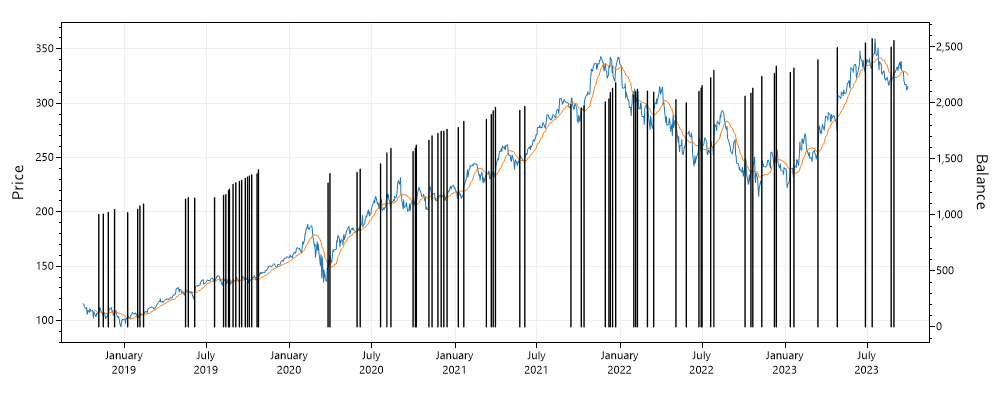

In [250]:
#r "nuget:ScottPlot, 4.1.68"

using System.Drawing;
using Microsoft.DotNet.Interactive.Formatting;
using ScottPlot;

Formatter.Register(typeof(Plot), (p, w) => 
    w.Write(((Plot)p).GetImageHTML()), HtmlFormatter.MimeType);

public static double ToOADate(this DateOnly date) => date.ToDateTime(default, DateTimeKind.Utc).ToOADate();

var plot = new Plot(1000, 400);
plot.XAxis.DateTimeFormat(true);
plot.YAxis.Label("Price");
plot.YAxis2.Label("Balance");
plot.YAxis2.Ticks(true);
/*
foreach (var e in trades)
{
    plot.AddVerticalLine(e.Buy.Date.ToOADate(), color: Color.Green);
    plot.AddVerticalLine(e.Sell.Date.ToOADate(), color: Color.Red, style: LineStyle.Dot);
}
*/
plot.AddScatter(data.Select(e => e.Date.ToOADate()).ToArray(),
                data.Select(e => (double)e.Price).ToArray(),
                markerShape: MarkerShape.none);

plot.AddScatter(mavg.Select(e => e.Date.ToOADate()).ToArray(),
                mavg.Select(e => (double)e.Avg).ToArray(),
                markerShape: MarkerShape.none);

/*
plot.AddScatter(run.Select(e => e.Sell.Date.ToOADate()).ToArray(),
                run.Select(e => (double)e.Balance).ToArray(),
                markerShape: MarkerShape.none)
    .YAxisIndex = 1;
*/
plot.AddBar(run.Select(e => (double)e.Balance).ToArray(),
            run.Select(e => e.Sell.Date.ToOADate()).ToArray())
    .YAxisIndex = 1;

plot
/*
plot = new Plot(1000, 400);
plot.XAxis.DateTimeFormat(true);
plot.AddBar(run.Select(e => (double)e.Balance).ToArray(),
            run.Select(e => e.Sell.Date.ToOADate()).ToArray());

plot.Display();
*/

In [245]:
var merged =
    data.OrderedMerge(run,
                      e => e.Date,
                      e => e.Sell.Date,
                      l => new { l.Date, l.Price, Balance = (decimal?)null },
                      r => throw new(),
                      (l, r) => new { l.Date, l.Price, Balance = (decimal?)r.Balance });

merged.Skip(20)

index value 0 { Date = 10/29/2018, Price = 103.849998, Balance = } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Balance <null> 1 { Date = 10/30/2018, Price = 103.730003, Balance = } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Balance <null> 2 { Date = 10/31/2018, Price = 106.809998, Balance = } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Balance <null> 3 { Date = 11/1/2018, Price = 105.919998, Balance = } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Balance <null> 4 { Date = 11/2/2018, Price = 106.160004, Balance = } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Balance <null> 5 { Date = 11/5/2018, Price = 107.510002, Balance = 1004.950027 } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Balance 1004.950027 6 { Date = 11/6/2018, Price = 107.720001, Balance = } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Balance <null> 7 { Date = 11/7/2018, Price = 111.959999, Balance = } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Balance <null> 8 { Date = 11/8/2018, Price = 111.750000, Balance = } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Balance <null> 9 { Date = 11/9/2018, Price = 109.570000, Balance = } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Balance <null> 10 { Date = 11/12/2018, Price = 106.870003, Balance = } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Balance <null> 11 { Date = 11/13/2018, Price = 106.940002, Balance = } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Balance <null> 12 { Date = 11/14/2018, Price = 104.970001, Balance = } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Balance <null> 13 { Date = 11/15/2018, Price = 107.279999, Balance = 1008.639991 } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Balance 1008.639991 14 { Date = 11/16/2018, Price = 108.290001, Balance = } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Balance <null> 15 { Date = 11/19/2018, Price = 104.620003, Balance = } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Balance <null> 16 { Date = 11/20/2018, Price = 101.709999, Balance = } Date 11/20/2018 Year 2018 Month 11 Day 20 DayOfWeek Tuesday DayOfYear 324 DayNumber 737017 Price 101.709999 Balance <null> 17 { Date = 11/21/2018, Price = 103.110001, Balance = } Date 11/21/2018 Year 2018 Month 11 Day 21 DayOfWeek Wednesday DayOfYear 325 DayNumber 737018 Price 103.110001 Balance <null> 18 { Date = 11/23/2018, Price = 103.070000, Balance = } Date 11/23/2018 Year 2018 Month 11 Day 23 DayOfWeek Friday DayOfYear 327 DayNumber 737020 Price 103.070000 Balance <null> 19 { Date = 11/26/2018, Price = 106.470001, Balance = 1025.289973 } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Balance 1025.289973 ... (more)

In [259]:
var filled = m.FillForward(e => e.Balance is null,
                           (e, f) => new { e.Date, e.Price, Balance = f.Balance ?? e.Balance });
 
filled

index value 0 { Date = 10/1/2018, Price = 115.610001, Balance = } Date 10/1/2018 Year 2018 Month 10 Day 1 DayOfWeek Monday DayOfYear 274 DayNumber 736967 Price 115.610001 Balance <null> 1 { Date = 10/2/2018, Price = 115.150002, Balance = } Date 10/2/2018 Year 2018 Month 10 Day 2 DayOfWeek Tuesday DayOfYear 275 DayNumber 736968 Price 115.150002 Balance <null> 2 { Date = 10/3/2018, Price = 115.169998, Balance = } Date 10/3/2018 Year 2018 Month 10 Day 3 DayOfWeek Wednesday DayOfYear 276 DayNumber 736969 Price 115.169998 Balance <null> 3 { Date = 10/4/2018, Price = 112.790001, Balance = } Date 10/4/2018 Year 2018 Month 10 Day 4 DayOfWeek Thursday DayOfYear 277 DayNumber 736970 Price 112.790001 Balance <null> 4 { Date = 10/5/2018, Price = 112.129997, Balance = } Date 10/5/2018 Year 2018 Month 10 Day 5 DayOfWeek Friday DayOfYear 278 DayNumber 736971 Price 112.129997 Balance <null> 5 { Date = 10/8/2018, Price = 110.849998, Balance = } Date 10/8/2018 Year 2018 Month 10 Day 8 DayOfWeek Monday DayOfYear 281 DayNumber 736974 Price 110.849998 Balance <null> 6 { Date = 10/9/2018, Price = 112.260002, Balance = } Date 10/9/2018 Year 2018 Month 10 Day 9 DayOfWeek Tuesday DayOfYear 282 DayNumber 736975 Price 112.260002 Balance <null> 7 { Date = 10/10/2018, Price = 106.160004, Balance = } Date 10/10/2018 Year 2018 Month 10 Day 10 DayOfWeek Wednesday DayOfYear 283 DayNumber 736976 Price 106.160004 Balance <null> 8 { Date = 10/11/2018, Price = 105.910004, Balance = } Date 10/11/2018 Year 2018 Month 10 Day 11 DayOfWeek Thursday DayOfYear 284 DayNumber 736977 Price 105.910004 Balance <null> 9 { Date = 10/12/2018, Price = 109.570000, Balance = } Date 10/12/2018 Year 2018 Month 10 Day 12 DayOfWeek Friday DayOfYear 285 DayNumber 736978 Price 109.570000 Balance <null> 10 { Date = 10/15/2018, Price = 107.599998, Balance = } Date 10/15/2018 Year 2018 Month 10 Day 15 DayOfWeek Monday DayOfYear 288 DayNumber 736981 Price 107.599998 Balance <null> 11 { Date = 10/16/2018, Price = 111.000000, Balance = } Date 10/16/2018 Year 2018 Month 10 Day 16 DayOfWeek Tuesday DayOfYear 289 DayNumber 736982 Price 111.000000 Balance <null> 12 { Date = 10/17/2018, Price = 110.709999, Balance = } Date 10/17/2018 Year 2018 Month 10 Day 17 DayOfWeek Wednesday DayOfYear 290 DayNumber 736983 Price 110.709999 Balance <null> 13 { Date = 10/18/2018, Price = 108.500000, Balance = } Date 10/18/2018 Year 2018 Month 10 Day 18 DayOfWeek Thursday DayOfYear 291 DayNumber 736984 Price 108.500000 Balance <null> 14 { Date = 10/19/2018, Price = 108.660004, Balance = } Date 10/19/2018 Year 2018 Month 10 Day 19 DayOfWeek Friday DayOfYear 292 DayNumber 736985 Price 108.660004 Balance <null> 15 { Date = 10/22/2018, Price = 109.629997, Balance = } Date 10/22/2018 Year 2018 Month 10 Day 22 DayOfWeek Monday DayOfYear 295 DayNumber 736988 Price 109.629997 Balance <null> 16 { Date = 10/23/2018, Price = 108.099998, Balance = } Date 10/23/2018 Year 2018 Month 10 Day 23 DayOfWeek Tuesday DayOfYear 296 DayNumber 736989 Price 108.099998 Balance <null> 17 { Date = 10/24/2018, Price = 102.320000, Balance = } Date 10/24/2018 Year 2018 Month 10 Day 24 DayOfWeek Wednesday DayOfYear 297 DayNumber 736990 Price 102.320000 Balance <null> 18 { Date = 10/25/2018, Price = 108.300003, Balance = } Date 10/25/2018 Year 2018 Month 10 Day 25 DayOfWeek Thursday DayOfYear 298 DayNumber 736991 Price 108.300003 Balance <null> 19 { Date = 10/26/2018, Price = 106.959999, Balance = } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Balance <null> ... (more)

In [247]:
var ff =
    from e in filled
    select new
    {
        e.Date,
        e.Price,
        Balance = e.Balance ?? 1_000m,
    };

ff.Skip(20)

index value 0 { Date = 10/29/2018, Price = 103.849998, Balance = 1000 } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Balance 1000 1 { Date = 10/30/2018, Price = 103.730003, Balance = 1000 } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Balance 1000 2 { Date = 10/31/2018, Price = 106.809998, Balance = 1000 } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Balance 1000 3 { Date = 11/1/2018, Price = 105.919998, Balance = 1000 } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Balance 1000 4 { Date = 11/2/2018, Price = 106.160004, Balance = 1000 } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Balance 1000 5 { Date = 11/5/2018, Price = 107.510002, Balance = 1004.950027 } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Balance 1004.950027 6 { Date = 11/6/2018, Price = 107.720001, Balance = 1004.950027 } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Balance 1004.950027 7 { Date = 11/7/2018, Price = 111.959999, Balance = 1004.950027 } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Balance 1004.950027 8 { Date = 11/8/2018, Price = 111.750000, Balance = 1004.950027 } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Balance 1004.950027 9 { Date = 11/9/2018, Price = 109.570000, Balance = 1004.950027 } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Balance 1004.950027 10 { Date = 11/12/2018, Price = 106.870003, Balance = 1004.950027 } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Balance 1004.950027 11 { Date = 11/13/2018, Price = 106.940002, Balance = 1004.950027 } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Balance 1004.950027 12 { Date = 11/14/2018, Price = 104.970001, Balance = 1004.950027 } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Balance 1004.950027 13 { Date = 11/15/2018, Price = 107.279999, Balance = 1008.639991 } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Balance 1008.639991 14 { Date = 11/16/2018, Price = 108.290001, Balance = 1008.639991 } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Balance 1008.639991 15 { Date = 11/19/2018, Price = 104.620003, Balance = 1008.639991 } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Balance 1008.639991 16 { Date = 11/20/2018, Price = 101.709999, Balance = 1008.639991 } Date 11/20/2018 Year 2018 Month 11 Day 20 DayOfWeek Tuesday DayOfYear 324 DayNumber 737017 Price 101.709999 Balance 1008.639991 17 { Date = 11/21/2018, Price = 103.110001, Balance = 1008.639991 } Date 11/21/2018 Year 2018 Month 11 Day 21 DayOfWeek Wednesday DayOfYear 325 DayNumber 737018 Price 103.110001 Balance 1008.639991 18 { Date = 11/23/2018, Price = 103.070000, Balance = 1008.639991 } Date 11/23/2018 Year 2018 Month 11 Day 23 DayOfWeek Friday DayOfYear 327 DayNumber 737020 Price 103.070000 Balance 1008.639991 19 { Date = 11/26/2018, Price = 106.470001, Balance = 1025.289973 } Date 11/26/2018 Year 2018 Month 11 Day 26 DayOfWeek Monday DayOfYear 330 DayNumber 737023 Price 106.470001 Balance 1025.289973 ... (more)

In [258]:
ff.OrderedMerge(actions,
                e => e.Date,
                a => a.Date,
                l => new { l.Date, l.Price, l.Balance, Action = (Trade?)null },
                r => throw new(),
                (l, r) => new { l.Date, l.Price, l.Balance, Action = (Trade?)r.Action })


.SkipWhile(e => e.Action is null)
.ToTabularDataResource()

index value 0 { Date = 10/26/2018, Price = 106.959999, Balance = 1000, Action = Buy } Date 10/26/2018 Year 2018 Month 10 Day 26 DayOfWeek Friday DayOfYear 299 DayNumber 736992 Price 106.959999 Balance 1000 Action Buy 1 { Date = 10/29/2018, Price = 103.849998, Balance = 1000, Action = } Date 10/29/2018 Year 2018 Month 10 Day 29 DayOfWeek Monday DayOfYear 302 DayNumber 736995 Price 103.849998 Balance 1000 Action <null> 2 { Date = 10/30/2018, Price = 103.730003, Balance = 1000, Action = } Date 10/30/2018 Year 2018 Month 10 Day 30 DayOfWeek Tuesday DayOfYear 303 DayNumber 736996 Price 103.730003 Balance 1000 Action <null> 3 { Date = 10/31/2018, Price = 106.809998, Balance = 1000, Action = } Date 10/31/2018 Year 2018 Month 10 Day 31 DayOfWeek Wednesday DayOfYear 304 DayNumber 736997 Price 106.809998 Balance 1000 Action <null> 4 { Date = 11/1/2018, Price = 105.919998, Balance = 1000, Action = } Date 11/1/2018 Year 2018 Month 11 Day 1 DayOfWeek Thursday DayOfYear 305 DayNumber 736998 Price 105.919998 Balance 1000 Action <null> 5 { Date = 11/2/2018, Price = 106.160004, Balance = 1000, Action = } Date 11/2/2018 Year 2018 Month 11 Day 2 DayOfWeek Friday DayOfYear 306 DayNumber 736999 Price 106.160004 Balance 1000 Action <null> 6 { Date = 11/5/2018, Price = 107.510002, Balance = 1004.950027, Action = Sell } Date 11/5/2018 Year 2018 Month 11 Day 5 DayOfWeek Monday DayOfYear 309 DayNumber 737002 Price 107.510002 Balance 1004.950027 Action Sell 7 { Date = 11/6/2018, Price = 107.720001, Balance = 1004.950027, Action = } Date 11/6/2018 Year 2018 Month 11 Day 6 DayOfWeek Tuesday DayOfYear 310 DayNumber 737003 Price 107.720001 Balance 1004.950027 Action <null> 8 { Date = 11/7/2018, Price = 111.959999, Balance = 1004.950027, Action = } Date 11/7/2018 Year 2018 Month 11 Day 7 DayOfWeek Wednesday DayOfYear 311 DayNumber 737004 Price 111.959999 Balance 1004.950027 Action <null> 9 { Date = 11/8/2018, Price = 111.750000, Balance = 1004.950027, Action = } Date 11/8/2018 Year 2018 Month 11 Day 8 DayOfWeek Thursday DayOfYear 312 DayNumber 737005 Price 111.750000 Balance 1004.950027 Action <null> 10 { Date = 11/9/2018, Price = 109.570000, Balance = 1004.950027, Action = } Date 11/9/2018 Year 2018 Month 11 Day 9 DayOfWeek Friday DayOfYear 313 DayNumber 737006 Price 109.570000 Balance 1004.950027 Action <null> 11 { Date = 11/12/2018, Price = 106.870003, Balance = 1004.950027, Action = Buy } Date 11/12/2018 Year 2018 Month 11 Day 12 DayOfWeek Monday DayOfYear 316 DayNumber 737009 Price 106.870003 Balance 1004.950027 Action Buy 12 { Date = 11/13/2018, Price = 106.940002, Balance = 1004.950027, Action = } Date 11/13/2018 Year 2018 Month 11 Day 13 DayOfWeek Tuesday DayOfYear 317 DayNumber 737010 Price 106.940002 Balance 1004.950027 Action <null> 13 { Date = 11/14/2018, Price = 104.970001, Balance = 1004.950027, Action = } Date 11/14/2018 Year 2018 Month 11 Day 14 DayOfWeek Wednesday DayOfYear 318 DayNumber 737011 Price 104.970001 Balance 1004.950027 Action <null> 14 { Date = 11/15/2018, Price = 107.279999, Balance = 1008.639991, Action = Sell } Date 11/15/2018 Year 2018 Month 11 Day 15 DayOfWeek Thursday DayOfYear 319 DayNumber 737012 Price 107.279999 Balance 1008.639991 Action Sell 15 { Date = 11/16/2018, Price = 108.290001, Balance = 1008.639991, Action = } Date 11/16/2018 Year 2018 Month 11 Day 16 DayOfWeek Friday DayOfYear 320 DayNumber 737013 Price 108.290001 Balance 1008.639991 Action <null> 16 { Date = 11/19/2018, Price = 104.620003, Balance = 1008.639991, Action = Buy } Date 11/19/2018 Year 2018 Month 11 Day 19 DayOfWeek Monday DayOfYear 323 DayNumber 737016 Price 104.620003 Balance 1008.639991 Action Buy 17 { Date = 11/20/2018, Price = 101.709999, Balance = 1008.639991, Action = } Date 11/20/2018 Year 2018 Month 11 Day 20 DayOfWeek Tuesday DayOfYear 324 DayNumber 737017 Price 101.709999 Balance 1008.639991 Action <null> 18 { Date = 11/21/2018, Price = 103.110001, Balance = 1008.639991, Action = } Date 11/21/2018 Year 2018 Month 11 Day 21 DayOfWeek Wed

In [194]:
#r "nuget: morelinq, 4.0.0"

using System.Globalization;
using MoreLinq;
using static System.Console;

enum Trade { Buy, Sell }

using var client = new HttpClient();
var csv = await client.GetStringAsync(@"https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1538524800&period2=1696291200&interval=1d&events=history&includeAdjustedClose=true");
// var csv = File.ReadAllText(@"C:\Downloads\MSFT.csv");

Regex.Split(csv, @"\r?\n")
    .Skip(1)
    .Select(line => line.Split(',', 7))
    .Where(fs => fs.Length is 7)
    .Select(fs => fs.Fold((dt, open, hi, lo, close, ac, vol) => new
    {
        Date = DateTime.Parse(dt),
        Price = decimal.Parse(close),
    }))
    .Window(20)
    .Select(w => new
    {
        w[^1].Date,
        w[^1].Price,
        Avg = w.Average(e => e.Price),
    })
    .Select(e => new
    {
        e.Date,
        e.Price,
        Action = e.Price < e.Avg ? Trade.Buy : Trade.Sell,
    })
    .GroupAdjacent(e => e.Action)
    .SkipWhile(e => e.Key is Trade.Sell)
    .Select(e => e.First())
    .Batch(2)
    .Where(b => b.Count() is 2)
    .Select(b => b.Fold((b, s) => new { Buy = b, Sell = s }))
    .Scan(new { Buy = new { Date = DateTime.MinValue, Price = 0m },
                Sell = new { Date = DateTime.MinValue, Price = 0m },
                Days = 0,
                Shares = 0, Account = 1_000m },
          (s, e) => new { Buy = new { e.Buy.Date, e.Buy.Price },
                          Sell = new { e.Sell.Date, e.Sell.Price },
                          Days = (int)(e.Sell.Date - e.Buy.Date).TotalDays,
                          Shares = (int)(s.Account / e.Buy.Price),
                          Account = (int)(s.Account / e.Buy.Price) * e.Sell.Price + (s.Account % e.Buy.Price) })
    /*
    .Scan(new { Date = DateTime.MinValue, Price = 0m, Action = "", Shares = 0, Portfolio = 0m, Account = 1_000m },
          (s, e) => e.Action is "BUY"
                  ? new
                    {
                        e.Date,
                        e.Price,
                        e.Action,
                        Shares = (int)Math.Floor(s.Account / e.Price),
                        Portfolio = (int)Math.Floor(s.Account / e.Price) * e.Price,
                        Account = s.Account % e.Price,
                    }
                  : new
                    {
                        e.Date,
                        e.Price,
                        e.Action,
                        Shares = 0,
                        Portfolio = 0m,
                        Account = s.Account + e.Price * s.Shares,
                    })
                    */


Installed Packages morelinq, 4.0.0

Error: (7,11): error CS1002: ; expected